In [28]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 199 µs (started: 2023-02-28 11:28:16 -05:00)


### Imports

In [29]:
# import numpy as np
import matplotlib.pyplot as plt  # required for plotting

import json
import pennylane as qml
import pennylane.numpy as np

import jax
import networkx as nx

from functools import partial

from pennylane.templates import ApproxTimeEvolution

from collections import Counter
import math
import importlib
import pickle
import os


from scipy.spatial.distance import jensenshannon

time: 383 µs (started: 2023-02-28 11:28:16 -05:00)


In [30]:
qml.version()

'0.28.0'

time: 906 µs (started: 2023-02-28 11:28:16 -05:00)


In [31]:
from utils import *

time: 244 µs (started: 2023-02-28 11:28:16 -05:00)


In [32]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

time: 1.01 ms (started: 2023-02-28 11:28:16 -05:00)


## Construct hamiltonian demo (simple graph example)

### run simulations for different time steps

In [33]:
### run the simulation for all graphs
n_max = 12
Gs = pickle.load(open(f'Datasets/PTC_graphs_max_{n_max}_nodes.p', 'rb'))
# build hamiltonians for all

# units for hbar = 1
omega = np.pi * 1e6  # rad / sec
delta = 0.7 * omega
hamiltonians = []
for graph in Gs:  
    hamiltonian_rydberg = build_hamiltonian(graph, omega, delta)
    hamiltonians.append(hamiltonian_rydberg)


time: 120 ms (started: 2023-02-28 11:28:16 -05:00)


In [34]:
n_wires = n_max
# n_wires = len(n_nodes)
print(n_wires)
wires = range(n_wires)
shots = 6000

dev = qml.device('default.qubit', wires=n_wires, shots=shots)


@qml.qnode(dev)
def circuit(time, hamiltonian, n_trotter_steps=100):
    ApproxTimeEvolution(hamiltonian, time, n_trotter_steps)
    return qml.counts(wires=wires)

12
time: 1.2 ms (started: 2023-02-28 11:28:16 -05:00)


In [35]:
t_range = np.linspace(1e-8, 5.*1e-6, 100)
my_nodesB = [0, 1, 4, 5]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    counts_results_graphs = []
    for hamiltonian in hamiltonians:
        n_trotter_steps = math.floor(t_max * 1e6) * 500 + 1
        # print(n_trotter_steps)
        counts_results = circuit(t_max, hamiltonian, n_trotter_steps)
        # print(counts_results)
        counts_results_graphs.append(counts_results)    
    results.append(counts_results_graphs)

KeyboardInterrupt: 

time: 5h 10min 32s (started: 2023-02-28 11:28:16 -05:00)


In [36]:
filename = f'results_pennylane_local_qubit_{n_max}.p'

if not os.path.isdir('results_QEK/'):
    os.mkdir('results_QEK/')
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))


time: 7.76 s (started: 2023-02-28 16:38:55 -05:00)


In [37]:
len(results)

55

time: 1.15 ms (started: 2023-02-28 16:39:16 -05:00)


In [38]:
t_range = t_range[:len(results)]

time: 183 µs (started: 2023-02-28 16:39:32 -05:00)


In [39]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, counts_graph in zip(t_range, results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

time: 1min 18s (started: 2023-02-28 16:40:12 -05:00)


Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

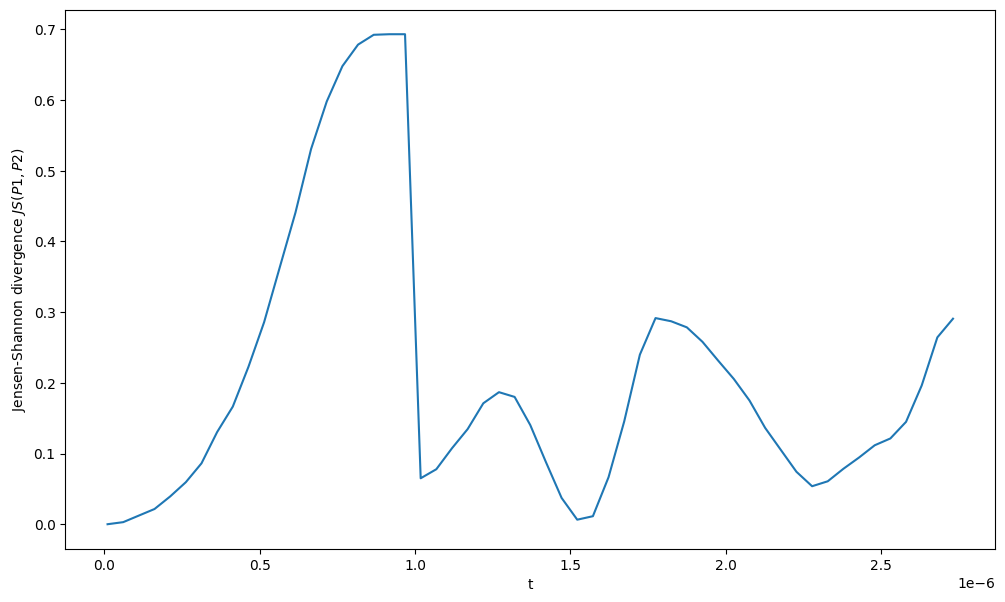

time: 191 ms (started: 2023-02-28 16:44:29 -05:00)


In [40]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [41]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, counts_graph in zip(t_range, results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

time: 2.5 s (started: 2023-02-28 16:44:38 -05:00)


Text(0.5, 0, 'Drive duration [s]')

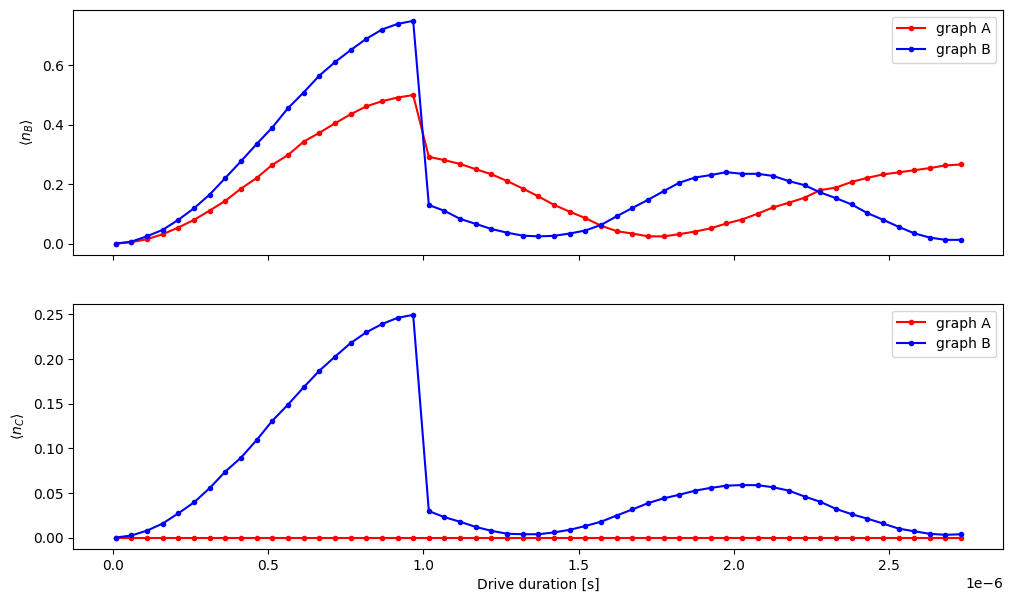

time: 174 ms (started: 2023-02-28 16:44:42 -05:00)


In [42]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

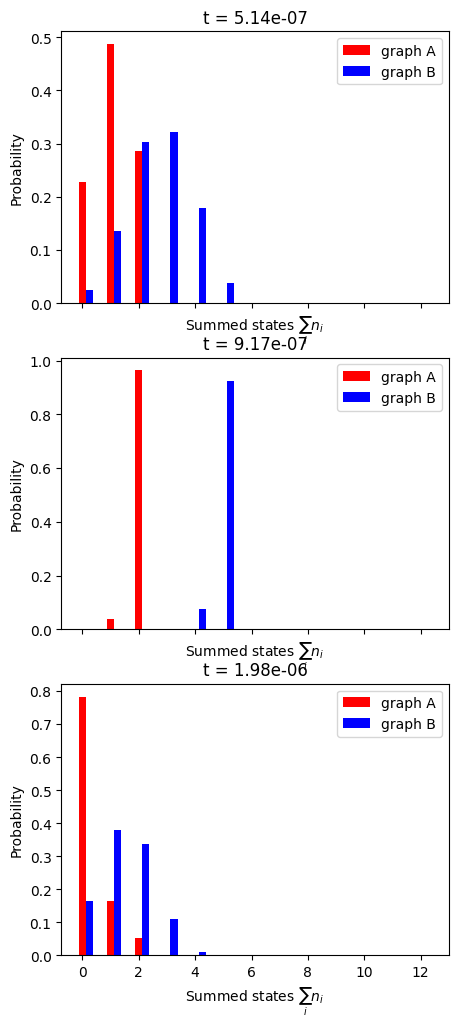

time: 292 ms (started: 2023-02-28 16:45:48 -05:00)


In [44]:
t_list = [0.5e-6, 0.9e-6, 2e-6]
barWidth = 0.25
br1 = np.arange(n_max+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = results[idx][i]
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))


